Applying a Savitzky-Golay Filter to the data.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search_targetpixelfile

from scipy.signal import savgol_filter

# From https://ui.adsabs.harvard.edu/abs/2023ApJS..265....4K/abstract
orbital_period = 2.79744256 #±0.00000041 
epoch_0 = 2457938.84392 # ±0.00016

# convert t0 to TESS BJD (BTJD)
epoch_0_BTJD = epoch_0 - 2457000.

def bin_flux(time, flux, binsize=120./86400.):
    binned_time = np.array([])
    binned_flux = np.array([])
    binned_err = np.array([])

    cur_point = np.min(time) + 0.5*binsize
    while(cur_point <= np.max(time) - 0.5*binsize):
        ind = np.abs(cur_point - time) < 0.5*binsize

        if(len(time[ind]) > 0):
            binned_time = np.append(binned_time, np.mean(time[ind]))
            binned_flux = np.append(binned_flux, np.mean(flux[ind]))
            binned_err = np.append(binned_err, np.std(flux[ind]))
        
        cur_point += binsize

    return binned_time, binned_flux, binned_err


LightCurveCollection of 11 objects:
    0: <TessLightCurve LABEL="TIC 267572272" SECTOR=26 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 267572272" SECTOR=40 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 267572272" SECTOR=41 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 267572272" SECTOR=53 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 267572272" SECTOR=54 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 267572272" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 267572272" SECTOR=59 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 267572272" SECTOR=74 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="TIC 267572272" SECTOR=75 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="TIC 267572272" SECTOR=80 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    10: <TessLightCurve LABEL="TIC 267572272

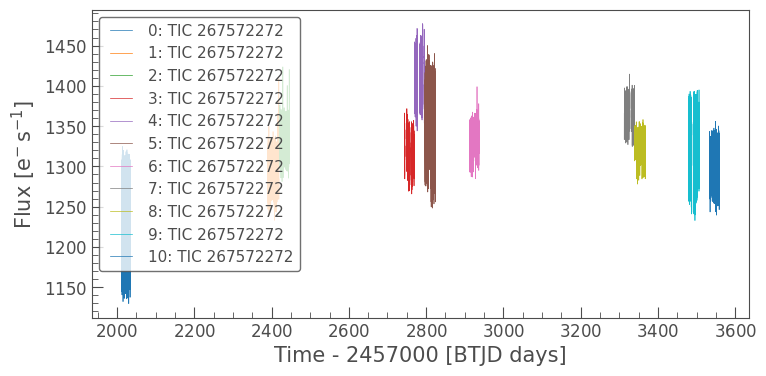

In [4]:
search_result = lk.search_lightcurve("TIC 267572272", author='SPOC', exptime='short')
search_result
tess_lc_collection = search_result.download_all()  # changed name of variable to make it easier to identify
print(tess_lc_collection)

for lc in tess_lc_collection:
    print("Sector ", lc.sector, "Crowdsap", lc.meta.get("CROWDSAP"), "flfrcsap", lc.meta.get("FLFRCSAP"))

tess_lc_collection.plot();

In [13]:
# 4/14 turn this cell into a function that can be used in other notebooks

def detrend_w_SavGol(sector_lc):
    # The light curves have nans in them, so we need to remove those points.
    cur_time = np.array(sector_lc.time.value)
    cur_flux = np.array(sector_lc.flux.value)
    ind = ~np.isnan(cur_flux)
    cur_time = cur_time[ind]
    cur_flux = cur_flux[ind]

    # Mask out transit
    known_transit_mask = (sector_lc.remove_nans()).create_transit_mask(transit_time=epoch_0_BTJD, period=orbital_period, duration=0.1)
    
    # Detrend out binary signal
    binary_period = 2.*sector_lc.to_periodogram(oversample_factor=10).period_at_max_power
    time_folded_on_binary_period = cur_time % binary_period.value

    # Bin folded flux
    binned_time, binned_flux, binned_err = bin_flux(time_folded_on_binary_period[~known_transit_mask], cur_flux[~known_transit_mask])

    # Now interpolate across whole time-series unfolded
    interp_trend = np.interp(time_folded_on_binary_period, binned_time, binned_flux)

    detrended_flux = cur_flux / interp_trend
    plt.scatter(cur_time % orbital_period, detrended_flux, marker='.') 

    return cur_time, detrended_flux

[2012.10364785 2012.10503676 2012.10642567 ... 3559.24416124 3559.2455501
 3559.24693896]


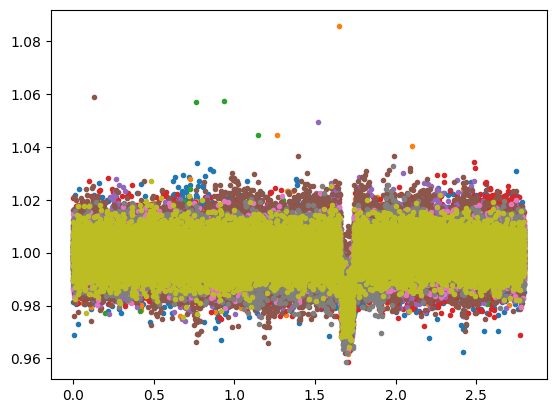

In [ ]:
# to collect detrend flux for the whole lc collection run the following
collection_time = []
collection_detrended_flux = []

for lc in tess_lc_collection:
    # Estimate binary period but NOT for sectors 59 or 74
    if(lc.sector not in [59, 74]):
        time, flux = detrend_w_SavGol(lc)
        collection_time.append(time)
        collection_detrended_flux.append(flux)                          

collection_time = np.concatenate(collection_time)
collection_detrended_time = np.concatenate(collection_detrended_flux)

<Axes: title={'center': 'TESS CBVs (Sector.Camera.CCD : 53.2.1, CBVType.Band : MultiScale.2)'}, xlabel='Time [btjd]'>

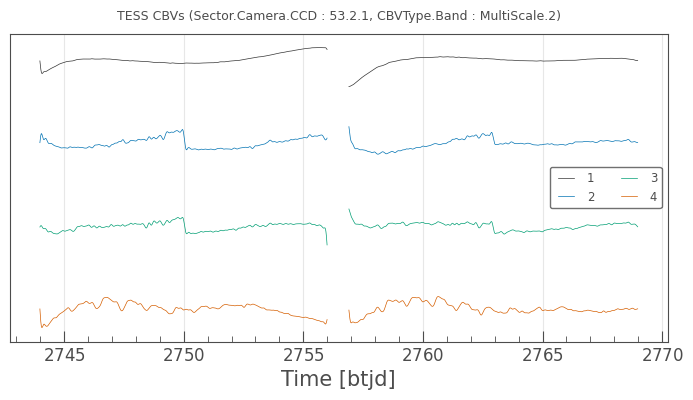

In [6]:
# look at Cotrending Basis Vectors used to create PDCSAP flux used in this notebook. 
lc = tess_lc_collection[3]
cbvs = lk.correctors.load_tess_cbvs(sector=lc.sector, camera=lc.camera, ccd=lc.ccd, cbv_type='MultiScale', band=2)
cbvs.plot(cbv_indices=np.arange(1,5))